# Volatilidad implícita
## Introducción


Pensemos en un activo cualquiera, este activo refleja una varianza histórica que podemos observar y medir.

Este activo puede ser subjacente de distintos tipos de derivados y como bien sabemos esto significa que el precio de estos dependerá de las distintas caracteristicas de nuestro subjacente.

In [26]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import scipy.stats as stats

In [27]:

ticker = yf.Ticker('AAPL')
prices = ticker.history(period="2y")['Close']
calls = ticker.option_chain(ticker.options[0]).calls


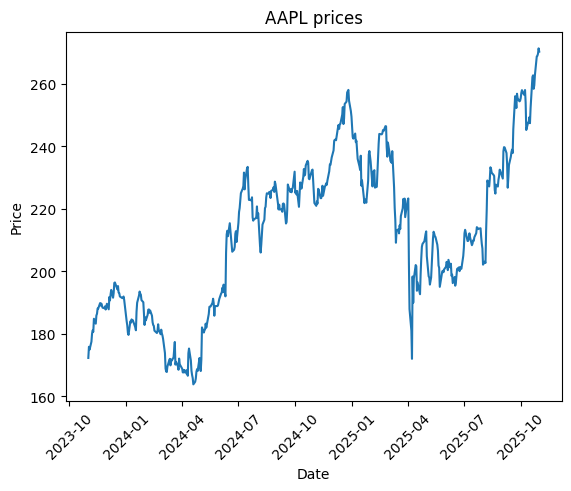

In [28]:
plt.plot(prices)
plt.title(f"{ticker.ticker} prices")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [29]:
current_price = prices.iloc[-1]
print("current price:",current_price)

current price: 270.3699951171875


Viendo el precio actual del activo y el histórico haga una estimacion vaga del precio de las siguientes opciones.

In [30]:
k=5
print(f"Expiration date: {ticker.options[0]}")
mask =(calls['strike']<=(current_price+k)) & (calls['strike']>=(current_price-k))
masked_calls = calls[mask][['contractSymbol','strike']]
masked_calls

Expiration date: 2025-11-07


,contractSymbol,strike
38,AAPL251107C00267500,267.5
39,AAPL251107C00270000,270.0
40,AAPL251107C00272500,272.5
41,AAPL251107C00275000,275.0


Podriamos usar otras herramisntas a nuestra dispocision para tener mas informacion y mejorar nuestra estimacion. Por ejemplo podemos calcular la probabilidad de que se ejecuten.

Si queremos calcular la probabilidad de que se ejecuten tenemos que usar el modelo
$$dS=S_0 \mu dt + S_0 \sigma dW$$

In [31]:
S_0 = current_price
mu = prices.pct_change().mean()
sigma = prices.pct_change().std()
t = (dt.datetime.today()-dt.datetime.strptime(ticker.options[0], "%Y-%m-%d")).days + 1
print(f"S_0: {current_price}")
print(f"mu: {mu}")
print(f"sigma: {sigma}")
print(f"dt: {t}")

S_0: 270.3699951171875
mu: 0.001054307699836557
sigma: 0.017677197516507235
dt: -3


Sabemos que el valor esperado del cambio en el precio del activo es

$$E[dS]=S_0 \mu dt$$

y la varianza esta dada por

$$Var[dS]= S_0^2 \sigma^2 dt$$


In [32]:
E = S_0*mu*t
Var = S_0**2*sigma**2*t
print(f"E[dS]: {E}")
print(f"Var[dS]: {Var}")

E[dS]: -0.8551595029704693
Var[dS]: -68.52752870157774


Con las siguientes probabilidades, ajusta tus estimaciones de cuanto crees que sea la prima de estas opciones call.

In [33]:
K = masked_calls['strike'].values
masked_calls['execution probability']=1-stats.norm.cdf((K-current_price),E,Var**0.5)
masked_calls

/tmp/ipython-input-3612538677.py:2: RuntimeWarning: invalid value encountered in scalar power
  masked_calls['execution probability']=1-stats.norm.cdf((K-current_price),E,Var**0.5)


,contractSymbol,strike,execution probability
38,AAPL251107C00267500,267.5,NaN
39,AAPL251107C00270000,270.0,NaN
40,AAPL251107C00272500,272.5,NaN
41,AAPL251107C00275000,275.0,NaN



### Precio justo de una opción (Black Scholes)

una herramienta mas potente para estimar el precio de las primas puede ser encontrar el precio justo usando black scholes

$$C(S, t) = S \cdot N(d_1) - K e^{-r(T-t)} \cdot N(d_2)$$

$$d_1 = \frac{\ln\left(\frac{S}{K}\right) + \left(r + \frac{\sigma^2}{2}\right)(T-t)}{\sigma\sqrt{T-t}}$$

$$d_2 = d_1 - \sigma\sqrt{T-t}
$$


In [34]:
r = (1+0.071)**(1/255)-1
d1 = (np.log(S_0/K) + (r + sigma**2/2)*t)/(sigma*t**0.5)
d2 = d1 - sigma*t**0.5
C = S_0*stats.norm.cdf(d1) - K*np.exp(-r*t)*stats.norm.cdf(d2)
masked_calls['fair price'] = C
masked_calls

,contractSymbol,strike,execution probability,fair price
38,AAPL251107C00267500,267.5,NaN,1.327007+3.114340j
39,AAPL251107C00270000,270.0,NaN,0.075997+3.301142j
40,AAPL251107C00272500,272.5,NaN,-1.175012+3.183577j
41,AAPL251107C00275000,275.0,NaN,-2.426021+2.753586j


Con esta nueva informacion ajusta una ultima vez tus estimaciones de las primas.

Para este punto habran notado que el precio de la prima baja cuando las opciones son mas riesgosas y sube cuando son mas seguras, por lo que haciendo de lado variables que no podemos cambiar como el intervalo de tiempo, el precio del activo o la tasa libre de riesgo, el precio de la prima de una opcion se puede ver como una funcion de la varianza (o volatilidad) del activo.

En el mercado podemos observar las siguientes primas `lastPrice` que son cercanas pero distintas al precio justo que calculamos. Ahora pregúntate:

Qué tan cercana fue tu estimación?
A qué crees que se deba la diferencia entre el precio justo y la prima que vemos en el mercado?



In [35]:
calls[mask]

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
38,AAPL251107C00267500,2025-10-31 19:59:19+00:00,267.5,5.26,5.15,5.40,-2.769999,-34.495636,3520.0,4245,0.302131,True,REGULAR,USD
39,AAPL251107C00270000,2025-10-31 19:59:58+00:00,270.0,3.79,3.65,3.90,-2.760000,-42.137410,30407.0,16332,0.294197,True,REGULAR,USD
40,AAPL251107C00272500,2025-10-31 19:59:59+00:00,272.5,2.61,2.47,2.63,-2.490000,-48.823530,32331.0,6888,0.283699,False,REGULAR,USD
41,AAPL251107C00275000,2025-10-31 19:59:59+00:00,275.0,1.60,1.58,1.72,-2.450000,-60.493830,40466.0,7205,0.280159,False,REGULAR,USD


La diferencia se debe a que en el mercado los precios de los derivados no son fijos, estan sujetos a movimientos segun su oferta y demanda.

Otra forma de ver esto es que el precio de la prima refleja la expectativa que el mercado tiene de la volatilidad en el periodo de la opcion.

Y si podemos calcular la prima en funcion a la volatilidad (Black Scholes), eso quiere decir que tambien podemos ver la volatilidad en funcion de la prima.

Para hacer esto podemos utilizar BS y metodos numericos:

In [44]:

from scipy.optimize import brentq

K=257.5
def BS(sigma):
  d1=(np.log(S_0/K)+(r+sigma**2/2)*t)/(sigma*np.sqrt(t))
  d2=d1-sigma*np.sqrt(t)
  c=S_0*stats.norm.cdf(d1)-K*np.exp(-r*t)*stats.norm.cdf(d2)
  return c

def objective(sigma):
    return BS(sigma) - 2.74

implied_vol = brentq(objective, -0.01, 0.07, xtol=1e-6)
print(f"La volatilidad implícita es: {implied_vol:.6f}  vs {sigma}")



La volatilidad implícita es: -0.000000  vs 0.017677197516507235


## Tarea

Comparar la volatilidad implicita de un grupo de opciones de un activo. con la varianza observada en dicho periodo.

Para lograr esto tenemos que calcular la volatilidad implicita de las opciones hoy, guardar esta informacion y regresar despues del vencimiento pera calcular la volatilidad del activo desde hoy hasta la fecha de vencimiento, compara con distintos timeframes y reflexiona sobre los resultados encontrados.

# Introducción
El pasado 23 de octubre de 2025 realizamos el cálculo de la volatilidad implícita de un conjunto de opciones sobre el activo LLY, tomando como referencia el precio spot y la información de mercado disponible en esa fecha. En ese momento obtuvimos los siguientes resultados:

𝑆0= 821.0399780273438

μ = 0.0009357011156510377

𝑑𝑡 = 7 días hasta el vencimiento

expiry = 31 de octubre de 2025

Las volatilidades implícitas estimadas para los strikes analizados fueron:

Strike 820.0 → IV = 0.029117

Strike 822.5 → IV = 0.029037

Estos valores representan la expectativa que el mercado tenía, en esa fecha t₀, sobre la variabilidad futura del activo hasta su vencimiento.

Hoy, 2 de noviembre de 2025, el vencimiento ya ha ocurrido.
Por lo tanto, en esta segunda parte procederemos a calcular la volatilidad realizada del activo desde la fecha inicial (23/10/2025) hasta la fecha efectiva de expiración (31/10/2025) y posteriormente compararemos dichos valores con las volatilidades implícitas estimadas previamente, para analizar si el mercado sobreestimó o subestimó la varianza futura y reflexionar sobre los resultados obtenidos.

In [51]:
TICKER = "LLY"
T0 = "2025-10-23"
EXPIRY = "2025-10-31"

px = yf.Ticker(TICKER).history(start=T0, end="2025-11-01")["Close"]
rets = np.log(px/px.shift(1)).dropna()
TRADING_DAYS = 252
rv_annual = np.sqrt(np.sum(rets**2) * (TRADING_DAYS / len(rets)))

print("Volatilidad realizada anualizada (T0 → Expiry):", rv_annual)

Volatilidad realizada anualizada (T0 → Expiry): 0.2906945914483413


In [52]:
rv_annual = 0.2906945914483413

# IV guardadas en t0 (23-oct-2025)
data = pd.DataFrame({
    "strike":  [820.0, 822.5],
    "iv_t0":   [0.029117, 0.029037],
})
data["rv_final"] = rv_annual

data["error_rel"] = data["rv_final"]/data["iv_t0"] - 1.0
data["VRP"] = data["iv_t0"]**2 - data["rv_final"]**2

print(data.round({"iv_t0":6, "rv_final":6, "error_rel":2, "VRP":4}))
data.to_csv("LLY_IV_vs_RV_final.csv", index=False)
print("\nGuardado: LLY_IV_vs_RV_final.csv")

   strike     iv_t0  rv_final  error_rel     VRP
0   820.0  0.029117  0.290695       8.98 -0.0837
1   822.5  0.029037  0.290695       9.01 -0.0837

Guardado: LLY_IV_vs_RV_final.csv


El 23/10/2025 estimamos la volatilidad implícita (IV) para LLY cercana a 2.9% anual en strikes próximos al dinero (820 y 822.5). Tras el vencimiento del 31/10/2025, la volatilidad realizada (RV) del periodo 23/10 al 31/10 resultó 0.2907 (29.07% anual), alrededor de 10 veces mayor que la IV. El error relativo del aproximadamente 900% indica que el mercado subestimó fuertemente la varianza del activo. Esto sugiere la presencia de algun evento no anticipado que elevó la volatilidad efectiva por encima.

In [53]:
px_expiry = yf.Ticker("LLY").history(start="2025-10-31", end="2025-11-01")["Close"]
S_T = float(px_expiry.iloc[-1])
print("Precio final de LLY el 31 oct 2025:", S_T)

Precio final de LLY el 31 oct 2025: 862.8599853515625


In [54]:
strike_1   = 820.0
premium_1  = 26.50

strike_2   = 822.5
premium_2  = 25.20

payoff_1 = max(S_T - strike_1, 0)
payoff_2 = max(S_T - strike_2, 0)

PnL_1 = payoff_1 - premium_1
PnL_2 = payoff_2 - premium_2

print("\n--- RESULTADOS ---")
print(f"Call 820  PnL por acción: {PnL_1:.2f}  → por contrato (x100): {PnL_1*100:.2f}")
print(f"Call 822.5  PnL por acción: {PnL_2:.2f}  → por contrato (x100): {PnL_2*100:.2f}")


--- RESULTADOS ---
Call 820  PnL por acción: 16.36  → por contrato (x100): 1636.00
Call 822.5  PnL por acción: 15.16  → por contrato (x100): 1516.00


# Fun fact
Si hubiéramos comprado estas dos opciones call el 23 de octubre el precio que mostraba el mercado (26.50 USD para el strike 820 y 25.20 USD para el strike 822.5), hubiésemos ganado dinero, ya que el 31 de Octubre cerró más arriba de ambos. El cierre del 31 de octubre fue aproximadamente 862.86 USD, lo cual generó un valor intrínseco de 42.86 USD para la call 820 y de 40.36 USD para la call 822.5.Por lo tanto, las utilidades netas (después de restar la prima pagada) hubieran sido aproximadamente de 16.36 USD y 15.16 USD por acción respectivamente (es decir ~1,636 USD y ~1,516 USD por contrato).